In [ ]:
!pip install tensorflow-quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 6.6 MB/s 
     |████████████████████████████████| 541 kB 51.9 MB/s 
     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 1.8 MB 40.5 MB/s 
     |████████████████████████████████| 100 kB 9.2 MB/s 
     |████████████████████████████████| 90 kB 7.9 MB/s 
     |████████████████████████████████| 6.1 MB 45.9 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 925 kB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 92 kB 1.1 MB

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf

In [ ]:
class PositionalEncoder:
    
    def __init__(self):
        pass

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self,position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def encode(self,x):
        
        _, len_seq, d_model = x.shape
        pos_enc=self.positional_encoding(len_seq, d_model)
        
        return pos_enc + x
    

class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self,*, d_attention, num_heads, input_dim):
        
        super(MultiHeadAttention,self).__init__()
        self.num_heads=num_heads
        self.d_attention=d_attention
        
        init = tf.random_normal_initializer()
        self.q_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim, d_attention), 
                                                        dtype="float32"),trainable=True)
        self.k_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim, d_attention), 
                                                        dtype="float32"),trainable=True)
        self.v_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim, d_attention), 
                                                        dtype="float32"),trainable=True)
        
        self.dense = tf.keras.layers.Dense(input_dim)
        
    def call(self,q,k,v, apply_look_ahead_mask, MASK):
        
        len_q = q.shape[1]
        
        q = tf.matmul(tf.stack([q]*self.num_heads,axis=1),self.q_weights)
        k = tf.matmul(tf.stack([k]*self.num_heads,axis=1),self.k_weights)
        v = tf.matmul(tf.stack([v]*self.num_heads,axis=1),self.v_weights)
        
        #multiply q and k and divide by sqrt(d_attention)
        attention_logits = tf.matmul(q, k, transpose_b=True)/tf.math.sqrt(tf.cast(self.d_attention, tf.float32))
        
        if MASK is not None:
            attention_logits = tf.math.add(attention_logits,MASK)
        
        if apply_look_ahead_mask:
            attention_logits=self.look_ahead_mask(attention_logits)
        
        #softmax
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        
        #multiply weights and v
        attention = tf.matmul(attention_logits, v) #(batch_size, num_heads, len_q, d_attention)
        
        #concatenate
        conc_attention = tf.reshape(attention, shape=(-1,len_q,self.d_attention*self.num_heads))
    
        #pass trough last linear layer
        attention_output = self.dense(conc_attention)
        
        return attention_output
    
    def add_look_ahead_mask(self,x): 

        len_q, len_k = x.shape[-2:]

        mask = 1 - tf.linalg.band_part(tf.ones((len_q, len_k)), -1, 0)
        mask*= -1e9

        return tf.math.add(x,mask) #(batch_size, num_heads, len_q, len_k)



class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, *, d_attention, num_heads, input_dim, dff, dropout_rate):
        
        super(EncoderLayer, self).__init__()
        
        #multihead attention sublayer
        self.mha = MultiHeadAttention(d_attention=d_attention, 
                                      num_heads=num_heads, 
                                      input_dim=input_dim)
        
        #ffw neural network sublayer
        self.ffn = tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  
                tf.keras.layers.Dense(input_dim)  
                ])
        
        #normalization sublayers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        #dropout sublayers(optional)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, MASK):
        
        mha_output = self.mha(x, x, x, apply_look_ahead_mask=False, MASK=MASK)  #mask argument is in call method of MHA
        mha_output = self.dropout1(mha_output, training=training)
        out1 = self.layernorm1(x + mha_output)  

        ffn_output = self.ffn(out1)  
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  

        return out2
    
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, *, num_layers, d_attention, num_heads, len_seq, input_dim, dff, dropout_rate, masking, resfilter):
        super(Encoder, self).__init__()
        
        if resfilter:
            self.filter = tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  
                tf.keras.layers.Dense(input_dim)  
                ])
        
        self.num_layers = num_layers
        self.pos_encoder = PositionalEncoder()
        self.masking=masking
        self.resfilter=resfilter
            
        self.enc_layers = [
            
            EncoderLayer(d_attention=d_attention, 
                         num_heads=num_heads,  
                         input_dim=input_dim, 
                         dff=dff,  
                         dropout_rate=dropout_rate) for i in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training):
        
        masks = [None for i in range(self.num_layers)]
        #first, eventually create the mask
        if self.masking:
            MASK=self.create_missing_timesteps_mask(x,x)
            masks[0] =MASK #we mask, eventually, only on the first encoder layer
                
        #then, eventually apply the mixing layer and create the res connection with the input, also adding positional encoder
        #or just apply pos encoder if mixing is false

        
        if self.resfilter:
            x_filtered = self.filter(x)
            x += x_filtered
        x = self.pos_encoder.encode(x)   
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, masks[i])

        return x  
    
    def create_missing_timesteps_mask(self,q,k):

        len_q = q.shape[1]
        len_k = k.shape[1]
        
        mask_value=0.

        query_mask_trigger = tf.cast(tf.reduce_any(q != mask_value, axis=2),'float32')
        key_mask_trigger = tf.cast(tf.reduce_any(k != mask_value, axis=2),'float32')
        
        query_mask_trigger = tf.reshape(query_mask_trigger, (-1,len_q,1))
        key_mask_trigger = tf.reshape(key_mask_trigger, (-1,1,len_k))
        
        MASK=tf.reshape((tf.matmul(query_mask_trigger,key_mask_trigger)-1)*1e9,shape=(-1,1,len_q,len_k))
        return MASK
    
class Encoder_Only_Transformer(tf.keras.Model):
    
    def __init__(self,*, num_layers, d_attention, num_heads, len_seq, input_dim, dff, dropout_rate=0.1, masking=False, resfilter):
        
        super(Encoder_Only_Transformer,self).__init__()
        
        self.encoder = Encoder(num_layers=num_layers, 
                               d_attention=d_attention, 
                               num_heads=num_heads, 
                               input_dim=input_dim, 
                               len_seq=len_seq,
                               dff=dff, 
                               dropout_rate=dropout_rate,
                               masking=masking,
                               resfilter=resfilter)

        self.flatten = tf.keras.layers.Flatten()
        self.dense= tf.keras.layers.Dense(64,activation='relu')
        self.dense2=tf.keras.layers.Dense(16, activation='relu')
        self.dense_out=tf.keras.layers.Dense(1,activation='linear')
        

    def call(self, inp, training):
        
        
        out = self.encoder(inp, training) 
        out = self.flatten(out)
        out = self.dense(out)
        out = self.dense2(out)
        out = self.dense_out(out)
        
        return out

In [ ]:
#callback for tracking progress on Drive
class Tracking(tf.keras.callbacks.Callback):
  
  def __init__(self,metrics,save_folder,exp_name,model):
    self.save_folder=save_folder
    self.model=model
    self.exp_name=exp_name
    self.tracking={"loss":[], "val_loss":[]}
    for newkey in metrics:
      self.tracking[newkey]=[]
      self.tracking['val_'+newkey]=[]

  def on_epoch_end(self, epoch, logs=None):
    keys = list(logs.keys())
    for key in keys:
      self.tracking[key].append(logs[key])
  
  def on_train_end(self, logs=None):
    tracking_df=pd.DataFrame.from_dict(self.tracking, orient='columns')
    path=self.save_folder+self.exp_name+'_history.csv'
    tracking_df.to_csv(path,index=False,encoding = 'utf-8-sig')
    path=self.save_folder+self.exp_name+'_model'
    self.model.save(path)

In [ ]:
def min_max_scaler(df_train,df_test,columns=None,MAX=1,MIN=0):
    
    if columns is None:
        columns = df_train.columns

    for col in columns:
        maximum = df_train.loc[:,col].max()
        minimum = df_train.loc[:,col].min()
        df_train.loc[:,col]=(MAX-MIN)*(df_train.loc[:,col]-maximum)/(maximum-minimum) + MAX
        df_test.loc[:,col]=(MAX-MIN)*(df_test.loc[:,col]-maximum)/(maximum-minimum) + MAX
        
    return df_train, df_test

def make_data(df_input,df_target,n_previous_days):   
    dates=df_input.index.date
    dates=np.unique(dates)
    
    inputs=[]
    outputs=[]
    
    for i in range(dates.shape[0]-n_previous_days):
        
        date0=dates[i].strftime('%Y-%m-%d')
        date1=dates[i+n_previous_days].strftime('%Y-%m-%d')
        
        date1_open_GHR = date1+ ' 11:00:00'
        date1_close_GHR = date1+ ' 14:00:00'
        
        max_ghr = df_target.loc[date1_open_GHR:date1_close_GHR].max()
        
        if math.isnan(max_ghr):
            pass
        
        else:
            
            outputs.append(max_ghr)
            
            date1_till_9 =  date1 +' 09:00:00'
            in_seq = df_input.loc[date0:date1_till_9].to_numpy()

            inputs.append(in_seq)
        
    return tf.constant(np.stack(inputs),dtype='float32'), tf.constant(np.stack(outputs).reshape(-1,1),dtype='float32')

df = pd.read_csv('/content/drive/MyDrive/TESI/3052-Site_Environment-DG_Weather_Station_04-2016_05-2022.csv')
df.Timestamp = df.Timestamp.astype(np.datetime64) #set 'Timestamp' to np.datetime type
df = df.set_index('Timestamp') # set 'Timestamp' column as index
df = df.resample('H').first() #Fill all the missing timesteps with Nan 
df = df.drop(columns=['Hail_Accumulation','Temperature_Probe_1','Temperature_Probe_2','Max_Wind_Speed','Pyranometer_1'])

df=df.loc[(df.index > '2016-05-17 23:00:00')]

df.interpolate()

unique_dates = np.unique(df.index.date)
split_value=0.8

split_date = unique_dates[int(split_value*unique_dates.shape[0])]
split_date = np.datetime64(split_date)

df_train = df.loc[:(split_date-1).item().strftime('%Y-%m-%d')]
df_test = df.loc[(split_date).item().strftime('%Y-%m-%d'):]

df_train_target=df_train['Global_Horizontal_Radiation'].copy(deep=True)
df_test_target=df_test['Global_Horizontal_Radiation'].copy(deep=True)

df_train_input , df_test_input = min_max_scaler(df_train, df_test)
MASK_VALUE=0.
df_train_input = df_train_input.fillna(MASK_VALUE)
df_test_input = df_test_input.fillna(MASK_VALUE)

inputs_train,outputs_train=make_data(df_train_input,df_train_target,2)
inputs_test,outputs_test=make_data(df_test_input,df_test_target,2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


#### Transformer without ResFilter

Define the model, the callbacks and compile

In [ ]:
#define the model (resfilter = False )
len_seq, input_dim=inputs_train.shape[-2:]
model_0=Encoder_Only_Transformer(num_layers=4, 
                               d_attention=64, 
                               num_heads=4, 
                               len_seq=len_seq, 
                               input_dim=input_dim, 
                               dff=128, 
                               resfilter=False)

#optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.0003)

#early stopping callback
earstop=tf.keras.callbacks.EarlyStopping(patience=20,
    restore_best_weights=True)

#tracking callback
metrics=['mean_squared_error','mean_absolute_error', 'mean_absolute_percentage_error']
save_fold='/content/drive/MyDrive/TESI/Transformer_vs_ResFilter_Transformer/'
exp_name='transformer'
tracking = Tracking(metrics,save_fold,exp_name,model_0)

model_0.compile(loss='log_cosh', optimizer=opt, metrics=metrics)

Fit the model

In [ ]:
%%time
model_0.fit(inputs_train,outputs_train,batch_size=32,validation_split=0.2,epochs=200,callbacks=[tracking,earstop])

Epoch 1/200
43/43 [==============================] - 1s 32ms/step - loss: 855.8022 - mean_squared_error: 769821.1875 - mean_absolute_error: 856.4955 - mean_absolute_percentage_error: 96.8061 - val_loss: 827.0833 - val_mean_squared_error: 722676.3750 - val_mean_absolute_error: 827.7764 - val_mean_absolute_percentage_error: 95.1493
Epoch 2/200
43/43 [==============================] - 1s 30ms/step - loss: 828.2178 - mean_squared_error: 723484.4375 - mean_absolute_error: 828.9109 - mean_absolute_percentage_error: 93.4048 - val_loss: 791.4478 - val_mean_squared_error: 664950.3750 - val_mean_absolute_error: 792.1409 - val_mean_absolute_percentage_error: 90.7224
Epoch 3/200
43/43 [==============================] - 1s 25ms/step - loss: 783.7121 - mean_squared_error: 651927.6875 - mean_absolute_error: 784.4052 - mean_absolute_percentage_error: 87.9658 - val_loss: 735.8282 - val_mean_squared_error: 579927.2500 - val_mean_absolute_error: 736.5214 - val_mean_absolute_percentage_error: 83.8129
Epoc

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TESI/Transformer_vs_ResFilter_Transformer/transformer_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TESI/Transformer_vs_ResFilter_Transformer/transformer_model/assets


CPU times: user 1min 24s, sys: 10 s, total: 1min 34s
Wall time: 1min 21s


Now make predictions: eventally here call the saved model from drive 

In [ ]:
predictions_0=model_0.predict(inputs_test)

**********************************************
TESTING METRICS SCORES:
Log Cosh Error87.9
Mean Squared Error:23490
Mean Absolute Error: 88.6
Mean Absolute Percentage Error10.21
**********************************************


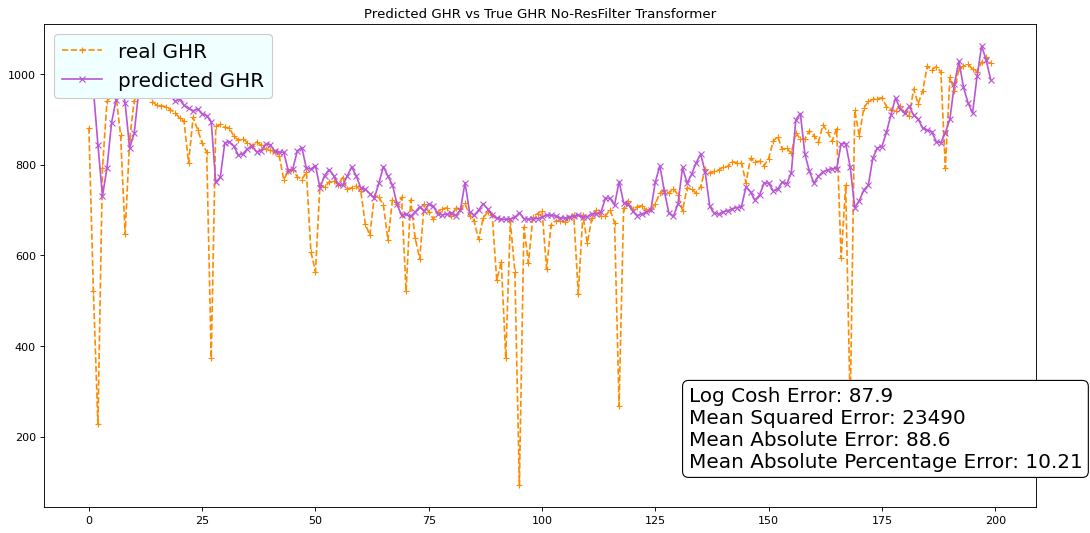

In [ ]:
mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh = tf.keras.metrics.LogCoshError()
logcosh.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh=round(logcosh.result().numpy(),1)
mse=int(round(mse.result().numpy(),0))
mae=round(mae.result().numpy(),1)
mape=round(mape.result().numpy(),2)

print('**********************************************')
print('TESTING METRICS SCORES:')
print("Log Cosh Error"+str(logcosh))
print("Mean Squared Error:" +str(mse)) 
print("Mean Absolute Error: " +str(mae))
print("Mean Absolute Percentage Error" +str(mape)) 

print('**********************************************')


fig = figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Predicted GHR vs True GHR No-ResFilter Transformer')
ax.plot(outputs_test[:200], label='real GHR', color='darkorange',ls='--', marker='+', markersize=6)
ax.plot(predictions_0[:200], label='predicted GHR', color='mediumorchid', marker='x', markersize=6)
ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper left", fontsize=18)


textstr = '\n'.join((
    "Log Cosh Error: "+str(logcosh),
    "Mean Squared Error: " +str(mse),
    "Mean Absolute Error: " +str(mae),
    "Mean Absolute Percentage Error: " +str(mape)))

props = dict(boxstyle='round', facecolor='white', alpha=1,)

# place a text box in upper left in axes coords
ax.text(0.65, 0.250, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

#plt.show()
plt.savefig(save_fold+'test_no_resfilter.png')

Transformer with ResFilter

In [ ]:
#define the model (resfilter = True)
len_seq, input_dim=inputs_train.shape[-2:]
model_1=Encoder_Only_Transformer(num_layers=4, 
                               d_attention=64, 
                               num_heads=4, 
                               len_seq=len_seq, 
                               input_dim=input_dim, 
                               dff=128, 
                               resfilter=True)

#optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.0003)

#early stopping callback
earstop=tf.keras.callbacks.EarlyStopping(patience=20,
    restore_best_weights=True)

#tracking callback
metrics=['mean_squared_error','mean_absolute_error', 'mean_absolute_percentage_error']
save_fold='/content/drive/MyDrive/TESI/Transformer_vs_ResFilter_Transformer/'
exp_name='transformer_resfilter'
tracking = Tracking(metrics,save_fold,exp_name,model_1)

model_1.compile(loss='log_cosh', optimizer=opt, metrics=metrics)

Fit the model

In [ ]:
%%time
model_1.fit(inputs_train,outputs_train,batch_size=32,validation_split=0.2,epochs=200,callbacks=[tracking,earstop])

Epoch 1/200
43/43 [==============================] - 8s 50ms/step - loss: 874.8349 - mean_squared_error: 802860.9375 - mean_absolute_error: 875.5282 - mean_absolute_percentage_error: 99.1325 - val_loss: 849.6329 - val_mean_squared_error: 760507.9375 - val_mean_absolute_error: 850.3260 - val_mean_absolute_percentage_error: 97.9513
Epoch 2/200
43/43 [==============================] - 1s 29ms/step - loss: 856.3445 - mean_squared_error: 770746.0000 - mean_absolute_error: 857.0377 - mean_absolute_percentage_error: 96.8809 - val_loss: 826.5222 - val_mean_squared_error: 721739.6250 - val_mean_absolute_error: 827.2153 - val_mean_absolute_percentage_error: 95.0804
Epoch 3/200
43/43 [==============================] - 1s 30ms/step - loss: 826.9478 - mean_squared_error: 721367.6250 - mean_absolute_error: 827.6409 - mean_absolute_percentage_error: 93.2579 - val_loss: 788.2117 - val_mean_squared_error: 659829.1875 - val_mean_absolute_error: 788.9048 - val_mean_absolute_percentage_error: 90.3210
Epoc

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TESI/Transformer_vs_ResFilter_Transformer/transformer_resfilter_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TESI/Transformer_vs_ResFilter_Transformer/transformer_resfilter_model/assets


CPU times: user 3min 33s, sys: 30.7 s, total: 4min 4s
Wall time: 2min 27s


Now make predictions: eventally here call the saved model from drive 

In [ ]:
predictions_1=model_1.predict(inputs_test)

**********************************************
TESTING METRICS SCORES:
Log Cosh Error57.4
Mean Squared Error:10745
Mean Absolute Error: 58.1
Mean Absolute Percentage Error7.85
**********************************************


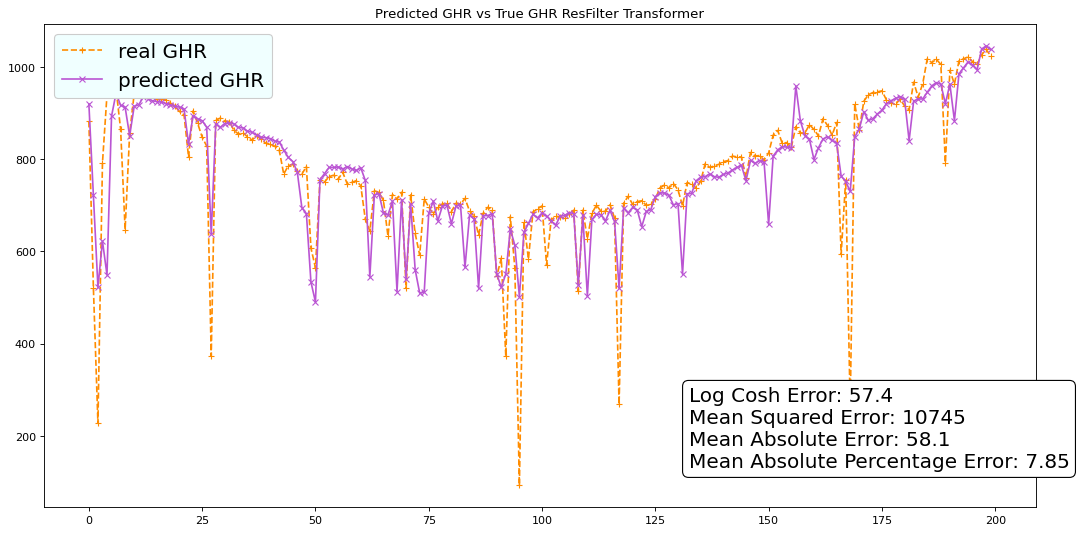

In [ ]:
mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh = tf.keras.metrics.LogCoshError()
logcosh.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh=round(logcosh.result().numpy(),1)
mse=int(round(mse.result().numpy(),0))
mae=round(mae.result().numpy(),1)
mape=round(mape.result().numpy(),2)

print('**********************************************')
print('TESTING METRICS SCORES:')
print("Log Cosh Error"+str(logcosh))
print("Mean Squared Error:" +str(mse)) 
print("Mean Absolute Error: " +str(mae))
print("Mean Absolute Percentage Error" +str(mape)) 

print('**********************************************')


fig = figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Predicted GHR vs True GHR ResFilter Transformer')
ax.plot(outputs_test[:200], label='real GHR', color='darkorange',ls='--', marker='+', markersize=6)
ax.plot(predictions_1[:200], label='predicted GHR', color='mediumorchid', marker='x', markersize=6)
ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper left", fontsize=18)


textstr = '\n'.join((
    "Log Cosh Error: "+str(logcosh),
    "Mean Squared Error: " +str(mse),
    "Mean Absolute Error: " +str(mae),
    "Mean Absolute Percentage Error: " +str(mape)))

props = dict(boxstyle='round', facecolor='white', alpha=1,)

# place a text box in upper left in axes coords
ax.text(0.65, 0.250, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)


plt.savefig(save_fold+'test_resfilter.png')

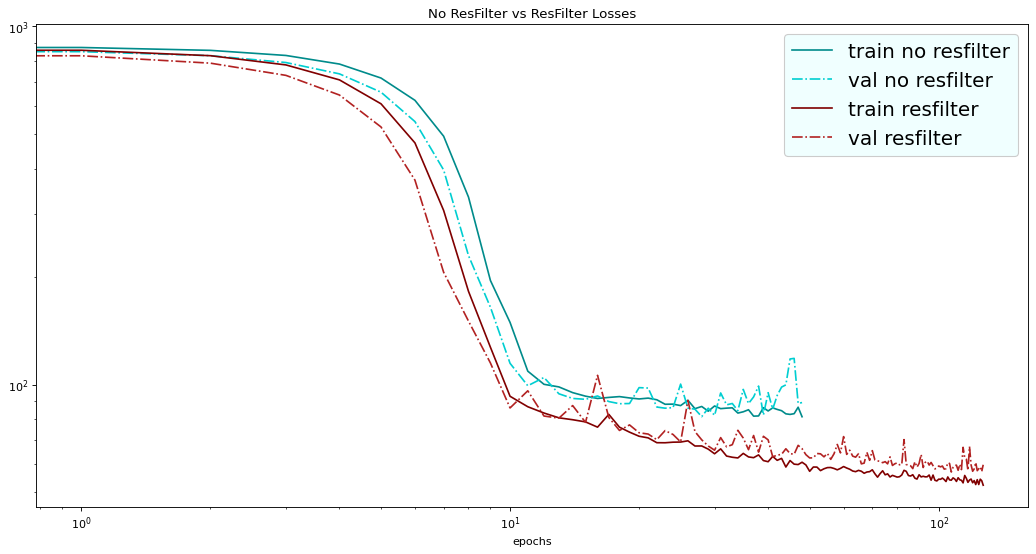

In [ ]:
history_0=pd.read_csv(save_fold+'transformer'+'_history.csv')
history_1=pd.read_csv(save_fold+'transformer_resfilter'+'_history.csv')

loss_0=history_0['loss'].to_numpy()
val_loss_0=history_0['val_loss'].to_numpy()
loss_1=history_1['loss'].to_numpy()
val_loss_1=history_1['val_loss'].to_numpy()

fig=figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('No-ResFilter vs ResFilter Losses')

ax.plot(loss_0, label='train no resfilter', c='darkcyan')
ax.plot(val_loss_0, label='val no resfilter', c='darkturquoise', ls='dashdot')

ax.plot(loss_1, label='train resfilter',  c='maroon' )
ax.plot(val_loss_1, label='val resfilter', c='firebrick', ls='dashdot')

ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper right", fontsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('epochs')


plt.savefig(save_fold+'losses_comparison.png')
